# Modelling
<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* Ridge and Lasso Regularization (add on to linear modelling?)

<u> Tests using the following variables:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables:
    * Sensor_id
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   


Normalise variables: should this be with MinMax or StandardScaler??


Process:
* Keep only data from sensor's with relatively complete data
* Split data into training ( 75%) and test (25%)
* Define the models to use in testing (linear regression, random forest, xgboost)
* Define the error metrics to use in evaluating the model performance

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
import xgboost as xgb
from sklearn.pipeline import Pipeline
import folium
import branca.colormap as cm
from eli5.sklearn import PermutationImportance
import joblib

from Functions import *

def prepend(list, str):
    str += '{0}'
    list = [str.format(i) for i in list]
    return(list)

### Define buffer size and input data filepath

In [2]:
buffer_size_m = 400
input_csv ="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)

### Read in data and drop spatial variables

In [3]:
# Read in data
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)
# Drop the spatial features
Xfull.drop(['transport_stops', 'betweenness', 'lights', 'street_inf', 'memorials', 'trees','bus-stops', 'tram-stops', 'metro-stations', 
            'taxi-ranks', 'big-car-parks', 'street_inf_Bicycle Rails', 'street_inf_Bollard','street_inf_Drinking Fountain',
            'street_inf_Floral Crate/Planter Box','street_inf_Horse Trough', 'street_inf_Information Pillar',
            'street_inf_Litter Bin', 'street_inf_Seat', 'street_inf_Tree Guard','landmarks_Community Use', 
            'landmarks_Mixed Use','landmarks_Place Of Assembly', 'landmarks_Place of Worship', 'landmarks_Retail', 
            'landmarks_Transport', 'landmarks_Education Centre','landmarks_Leisure/Recreation', 'landmarks_Office',
       'street_inf_Barbeque', 'street_inf_Hoop', 'street_inf_Picnic Setting', 'landmarks_Specialist Residential Accommodation',
       'landmarks_Vacant Land', 'landmarks_Purpose Built','landmarks_Health Services', 'avg_n_floors', 'buildings_Community Use',
       'buildings_Education', 'buildings_Entertainment', 'buildings_Events','buildings_Hospital/Clinic', 'buildings_Office', 'buildings_Parking',
       'buildings_Public Display Area', 'buildings_Residential','buildings_Retail', 'buildings_Storage', 'buildings_Unoccupied',
       'buildings_Working', 'buildings_Transport'], axis=1, inplace = True)

In [4]:
# Xfull = Xfull[['year', 'Temp', 'Sin_time', 'Cos_time']]
Xfull

,year,Temp,Humidity,Pressure,Rain,WindSpeed,Rainfall amount (millimetres),public_holiday,school_holiday,Monday,...,month_11,month_12,Sin_time,Cos_time,Sin_month_num,Cos_month_num,Sin_weekday_num,Cos_weekday_num,random,random_cat
0,2011,23.0,57.0,1008.0,0,6.0,0.0,0.0,0.0,0,...,0,0,0.000000e+00,1.0,0.500000,0.866025,-0.781831,0.62349,0.084565,2
1,2011,23.0,57.0,1008.0,0,6.0,0.0,0.0,0.0,0,...,0,0,0.000000e+00,1.0,0.500000,0.866025,-0.781831,0.62349,0.055584,0
2,2011,23.0,57.0,1008.0,0,6.0,0.0,0.0,0.0,0,...,0,0,0.000000e+00,1.0,0.500000,0.866025,-0.781831,0.62349,0.140188,2
3,2011,23.0,57.0,1008.0,0,6.0,0.0,0.0,0.0,0,...,0,0,0.000000e+00,1.0,0.500000,0.866025,-0.781831,0.62349,0.559682,2
4,2011,23.0,57.0,1008.0,0,6.0,0.0,0.0,0.0,0,...,0,0,0.000000e+00,1.0,0.500000,0.866025,-0.781831,0.62349,0.904525,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4129077,2022,24.0,60.0,995.0,0,30.5,0.0,0.0,0.0,1,...,0,0,-2.449294e-16,1.0,-0.866025,0.500000,0.781831,0.62349,0.560612,1
4129078,2022,24.0,60.0,995.0,0,30.5,0.0,0.0,0.0,1,...,0,0,-2.449294e-16,1.0,-0.866025,0.500000,0.781831,0.62349,0.769146,2
4129079,2022,24.0,60.0,995.0,0,30.5,0.0,0.0,0.0,1,...,0,0,-2.449294e-16,1.0,-0.866025,0.500000,0.781831,0.62349,0.739935,0
4129080,2022,24.0,60.0,995.0,0,30.5,0.0,0.0,0.0,1,...,0,0,-2.449294e-16,1.0,-0.866025,0.500000,0.781831,0.62349,0.710525,1


In [5]:
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import cross_val_predict
# from sklearn.metrics import mean_absolute_error

# # Load the dataset
# data = pd.read_csv('your_dataset.csv')

# # Select the predictor variables and target variable
# predictors = ['day', 'month', 'year', 'time', 'rainfall']
# target = 'footfall counts'

# # Compute the mean footfall across the three sensors for each datetime
# mean_footfall = data.groupby(['day', 'month', 'year', 'time'])[target].mean().reset_index()

# # Merge mean footfall with original data based on datetime
# merged_data = pd.merge(data, mean_footfall, on=['day', 'month', 'year', 'time'], suffixes=('', '_mean'))

# # Select merged data with mean predictions as predictors and individual footfall counts as the target for each sensor
# sensor_errors = {}
# for sensor_id in range(1, 4):
#     sensor_data = merged_data[merged_data['sensor_id'] == sensor_id]
#     sensor_predictors = sensor_data[predictors]
#     sensor_target = sensor_data[target]
    
#     # Define the Random Forest regressor
#     rf_model = RandomForestRegressor()
    
#     # Perform cross-validation
#     predictions = cross_val_predict(rf_model, sensor_predictors, sensor_target, cv=5)
    
#     # Evaluate the model using mean absolute error
#     mae = mean_absolute_error(sensor_target, predictions)
#     sensor_errors[sensor_id] = mae

# # Print the error scores for each sensor
# for sensor_id, mae in sensor_errors.items():
#     print(f"Sensor {sensor_id} - Mean Absolute Error: {mae}")

### Find the mean hourly counts per hour

In [6]:
# Join the datetime column as this needed for the mean calculation
datetime_col = data_time_columns['datetime']
# Join date columns as they are needed for this analysis
data = pd.concat([Xfull, datetime_col], axis=1)
# Add hourly counts
data['hourly_counts'] = Yfull
# Find the mean count per hour
mean_hourly_counts =data.groupby(['datetime']).mean()

### Split back into X and Y variables

In [7]:
# The predictor variables
Xfull = mean_hourly_counts.drop(['hourly_counts'], axis =1)
# The variable to be predicted
Yfull = mean_hourly_counts['hourly_counts'].values

### Choose which date based variables to use

In [8]:
Xfull.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
   'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
   'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace = True)

## Define model pipelines (linear regression, random forest and XGBoost)
Include process to scale the data

In [9]:
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 32)]])

## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validatio

In [10]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
cv_parameters = KFold(n_splits=10, random_state=1, shuffle=True)

### Loop through each combination of the models, and the variables to include in the modelling

In [11]:
# Dataframe to store the scores for each model
error_metric_scores = pd.DataFrame()

# Dictionary to store dataframes of feature importance scores
predictions_df = pd.DataFrame()

# Dictionary to store dataframes of feature importance scores
feature_importance_scores ={}

model_name = 'rf_regressor'
model = rf_model_pipeline
regex_name = 'withsubtypes'
regex = 'buildings$|furniture$|landmarks$'
        
# Run the model: return the estimators and a dataframe containing evaluation metrics
estimators, error_metrics_df, feature_list, predictions = run_model_with_cv_and_predict(
    model, model_name, error_metrics, cv_parameters, Xfull, Yfull, regex_name, regex, buffer_size_m) 
# Add evaluation metric scores for this model to the dataframe containing the metrics for each model
error_metric_scores = error_metric_scores.append(error_metrics_df)

predictions_df[model_name] =predictions

# Create dataframe of feature importances (no feature importances for linear regression)
if model_name != 'linear_regressor':
    feature_importances = pd.DataFrame(index =[feature_list])
    for idx,estimator in enumerate(estimators):
            feature_importances['Estimator{}'.format(idx)] = estimators[idx][model_name].feature_importances_
    feature_importance_scores["{}_{}".format(model_name, regex_name)] = feature_importances

#         filename = 'PickleFiles/CV/{}_aggregatedmodel/{}_cv_estimators.pkl'.format(buffer_size_m, model_name)
#         joblib.dump(estimators, filename)

Running rf_regressor model, variables include withsubtypes
running cross_validate
ran cross_validate
running cross_val_predict
ran cross_val_predict
Ran in 1 minutes


### Print the accuracy scores

In [12]:
error_metric_scores

,mae,map,r2,rmse
400_withsubtypes,39.37,1.282504e+13,0.96,64.07


### Plot the predicted vs actual values from the CV process
Within cross validation each data point is included in the test set only once and thus despite their beng multiple cross-validation folds, each true value of Y has only one associated prediction 

In [31]:
test=pd.DataFrame({'PredictedCounts':predictions}, index=Xfull.index)
test

,PredictedCounts
datetime,
2011-01-01 00:00:00,456.048055
2011-01-01 01:00:00,157.367478
2011-01-01 02:00:00,105.183464
2011-01-01 03:00:00,66.887877
2011-01-01 04:00:00,31.803542
...,...
2022-10-31 19:00:00,363.123707
2022-10-31 20:00:00,329.351088
2022-10-31 21:00:00,270.244952


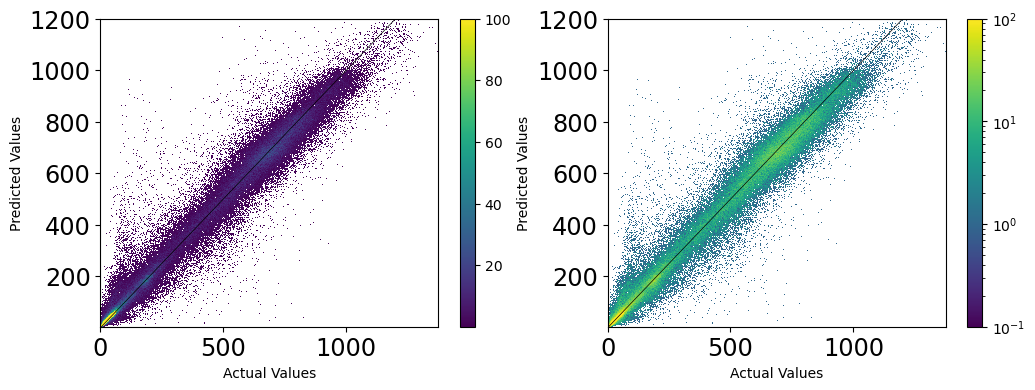

In [32]:
fig, axs = plt.subplots(ncols=2, figsize = (12,4))
using_datashader(axs[0], Yfull, predictions, 'linear')
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
axs[0].xaxis.set_tick_params(labelsize='xx-large')
axs[0].yaxis.set_tick_params(labelsize='xx-large')

using_datashader(axs[1], Yfull, predictions, 'log')
axs[1].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
axs[1].xaxis.set_tick_params(labelsize='xx-large')
axs[1].yaxis.set_tick_params(labelsize='xx-large')

### Feature importances from within cross-validation
If reporting feature importances from the model, then would use those from fitting the final model on the full dataset. However, this is useful as a measure of the stability of the feature importances that the model reports

In [19]:
feature_importances_df = feature_importance_scores["rf_regressor_withsubtypes"].copy()
feature_importances_df.reset_index(inplace=True)
feature_importances_df.rename(columns={'level_0':'Variable'},inplace=True)

#### Top 10 features for each estimator

In [20]:
important_columns=pd.DataFrame()
for column in feature_importances_df.columns[1:]:
    this_col = feature_importances_df[['Variable', column]]
    important_columns[column] = this_col.sort_values(column, ascending = False)['Variable'].tolist()#[0:10]
important_columns    

,Estimator0,Estimator1,Estimator2,Estimator3,Estimator4,Estimator5,Estimator6,Estimator7,Estimator8,Estimator9
0,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time
1,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time
2,year,year,year,year,year,year,year,year,year,year
3,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num
4,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num
5,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num
6,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num
7,Temp,Temp,Temp,Temp,Temp,Temp,Temp,Temp,Temp,Temp
8,Pressure,Pressure,Pressure,Pressure,Pressure,Pressure,Pressure,Pressure,Pressure,Pressure
9,Humidity,Humidity,Humidity,Humidity,Humidity,Humidity,Humidity,Humidity,Humidity,Humidity


In [21]:
pi_raw = []
pi_ls = []
for estimator in estimators:
    pi, pi_raw = find_permutation_importance(estimator['rf_regressor'], Xfull, Yfull, n_iter=3)  
    pi_ls.append(pi)
    pi_raw.append(pi_raw)

### Find permutation importance from within Cross validation

In [22]:
important_columns=pd.DataFrame()
for i in list(range(0,len(pi_ls))):
    test=pi_ls[i].sort_values('importance', ascending = False)[0:25]
    test.reset_index(inplace=True, drop=True)
    important_columns["PI{}".format(i)] = test['feature']
important_columns

,PI0,PI1,PI2,PI3,PI4,PI5,PI6,PI7,PI8,PI9
0,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time
1,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time
2,Sin_weekday_num,Cos_weekday_num,Cos_weekday_num,Sin_weekday_num,Cos_weekday_num,Sin_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Sin_weekday_num
3,Cos_weekday_num,Sin_weekday_num,Sin_weekday_num,Cos_weekday_num,Sin_weekday_num,Cos_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Cos_weekday_num
4,Rainfall amount (millimetres),Rainfall amount (millimetres),Rainfall amount (millimetres),Rainfall amount (millimetres),Sin_month_num,Rainfall amount (millimetres),Rainfall amount (millimetres),Rainfall amount (millimetres),Rainfall amount (millimetres),Rainfall amount (millimetres)
5,random_cat,Pressure,Temp,Pressure,Cos_month_num,Pressure,Pressure,Pressure,Pressure,random_cat
6,Humidity,Temp,Pressure,Temp,Rainfall amount (millimetres),random_cat,Temp,random,random_cat,Pressure
7,Pressure,school_holiday,Humidity,year,Pressure,Humidity,Humidity,school_holiday,random,school_holiday
8,Temp,Rain,year,Rain,random,school_holiday,school_holiday,public_holiday,Rain,year
9,Rain,year,Rain,school_holiday,school_holiday,year,year,year,school_holiday,public_holiday
